In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [3]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)


In [4]:
# Get the shape of the first image in the training dataset
image, label = train_dataset[0]
print("Image shape:", image.shape)
print("Number of training samples:", len(train_dataset))

Image shape: torch.Size([1, 28, 28])
Number of training samples: 60000


In [5]:
# Get the shape of the first image in the test dataset
image, label = test_dataset[0]
print("Image shape:", image.shape)
print("Number of testing samples:", len(test_dataset))

Image shape: torch.Size([1, 28, 28])
Number of testing samples: 10000


In [6]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1=nn.Linear(128*3*3,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
      x=self.pool(torch.relu(self.conv1(x)))
      x=self.pool(torch.relu(self.conv2(x)))
      x=self.pool(torch.relu(self.conv3(x)))
      x=x.view(x.size(0),-1)
      x=torch.relu(self.fc1(x))
      x=torch.relu(self.fc2(x))
      x=self.fc3(x)
      return x

In [8]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)   # flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

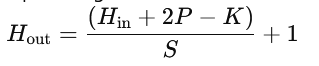

In [9]:
from torchsummary import summary

# Initialize model
model = CNNClassifier()

# Move model to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)

# Print model summary

print('Name:  GURUMURTHY S')
print('Register Number:  212223230066')
summary(model, input_size=(1, 28, 28))


Name:  GURUMURTHY S
Register Number:  212223230066
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass

In [10]:
# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model, loss function, optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [11]:
def train_model(model, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [12]:

# Train the model
train_model(model, train_loader, num_epochs=10)

Epoch [1/10], Loss: 0.1658
Epoch [2/10], Loss: 0.0600
Epoch [3/10], Loss: 0.0450
Epoch [4/10], Loss: 0.0371
Epoch [5/10], Loss: 0.0294
Epoch [6/10], Loss: 0.0250
Epoch [7/10], Loss: 0.0208
Epoch [8/10], Loss: 0.0198
Epoch [9/10], Loss: 0.0160
Epoch [10/10], Loss: 0.0148


In [13]:
## Step 4: Test the Model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    
    print('Name:  GURUMURTHY S')
    print('Register Number:  212223230066')
    print(f'Test Accuracy: {accuracy:.4f}')
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    print('Name:  GURUMURTHY S')
    print('Register Number:  212223230066')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    # Print classification report
    print('Name:  GURUMURTHY S')
    print('Register Number:  212223230066')
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

Name: 
Register Number: 
Test Accuracy: 0.9899
Name: 
Register Number: 


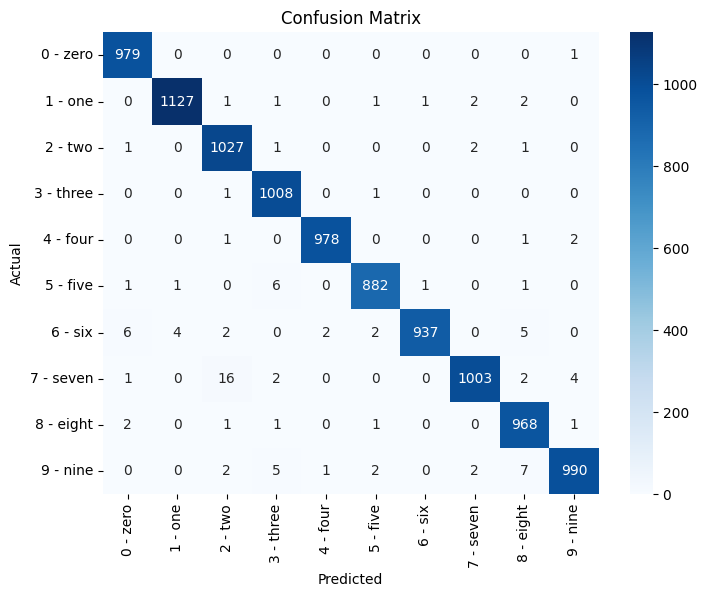

Name: 
Register Number: 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.98      1.00      0.99      1010
           4       1.00      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [14]:

# Evaluate the model
test_model(model, test_loader)

In [15]:

## Step 5: Predict on a Single Image
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    if torch.cuda.is_available():
        image = image.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    class_names = [str(i) for i in range(10)]

    
    print('Name:Sanjay C')
    print('Register Number: 212223240150')
    plt.imshow(image.cpu().squeeze(), cmap="gray")
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()
    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}')


Name: 
Register Number: 


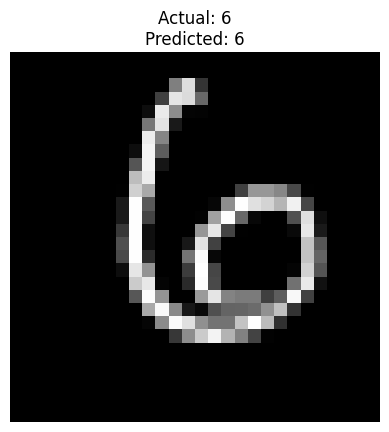

Actual: 6, Predicted: 6


In [17]:

# Example Prediction
predict_image(model, image_index=100, dataset=test_dataset)